# Extract Features from Test Set

This notebook loads the test set data, performs feature engineering (e.g., trimming, slope calculations, and mean gradients), and exports the processed test set as a pickle file.

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

# set visualization flag
VISUALIZE = True

# Path to the test set pickle file
input_test_file = "../resources/raw/test_bat_data.pkl"

# Load the test set
with open(input_test_file, "rb") as file:
    test_dict = pickle.load(file)

print(f"Loaded {len(test_dict)} batteries from the test set")

Loaded 40 batteries from the test set


# Visualize a Sample Battery

Sample Battery ID: b3c0
First 10 q_d_n values: [1.0665727853775024, 1.0674550533294678, 1.0682848691940308, 1.0687084197998047, 1.0690935850143433, 1.0694149732589722, 1.069730520248413, 1.0699872970581055, 1.0702369213104248, 1.0704190731048584]


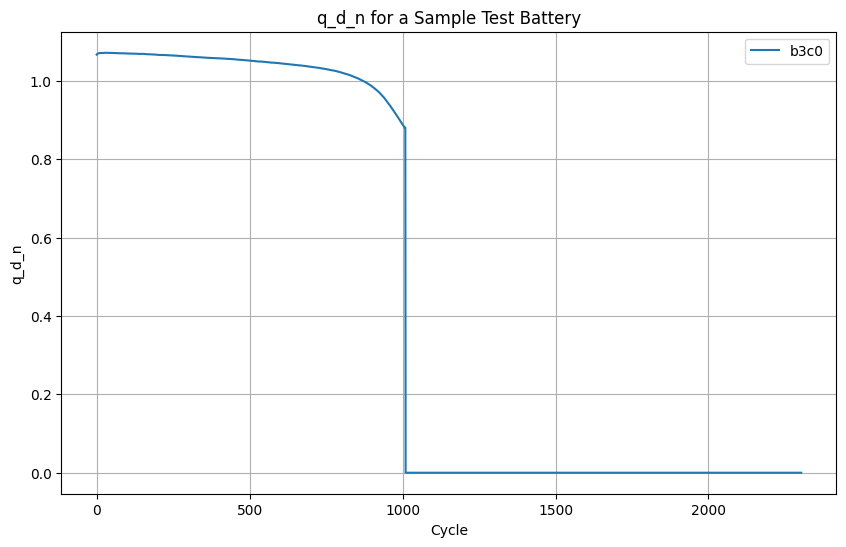

In [3]:
sample_battery_id = list(test_dict.keys())[0]
print(f"Sample Battery ID: {sample_battery_id}")
print(f"First 10 q_d_n values: {test_dict[sample_battery_id]['q_d_n'][:10]}")

if VISUALIZE:
    plt.figure(figsize=(10, 6))
    x_values = list(range(len(test_dict[sample_battery_id]['q_d_n'])))
    plt.plot(x_values, test_dict[sample_battery_id]['q_d_n'], label=sample_battery_id)
    plt.xlabel('Cycle')
    plt.ylabel('q_d_n')
    plt.title('q_d_n for a Sample Test Battery')
    plt.legend()
    plt.grid(True)
    plt.show()

# Save to resource

In [5]:
for battery_id, data in test_dict.items():
    q_d_n = data.get('q_d_n')
    if q_d_n is not None:
        try:
            with open(f"../resources/raw/{battery_id}.txt", "w") as f:
                for val in q_d_n:
                    f.write(f"{val},\n")
        except Exception as e:
            print(f"Error saving {battery_id}: {e}")
    else:
        print(f"Missing 'q_d_n' for {battery_id}")


# Feature Engineering for Test Set

The following cells perform feature extraction on each battery in the test set. The steps include:

- Trimming the trailing zeros from the `q_d_n` array.
- Calculating the overall slope from the first to the last cycle.
- Calculating the slope over the last *k* cycles (if there are enough cycles).
- Calculating the mean gradient of the last *k* cycles.

Adjust the list of `k` values as needed.

In [ ]:
# Ensure each battery has a 'cycle' field. If not, assume cycle count equals length of q_d_n
for battery_id in test_dict:
    if 'cycle' not in test_dict[battery_id]:
        test_dict[battery_id]['cycle'] = len(test_dict[battery_id]['q_d_n'])

# Trim trailing zeros from q_d_n and store as 'trimmed_q_d_n'
for battery_id in test_dict:
    trimmed_arr = np.trim_zeros(test_dict[battery_id]['q_d_n'], 'b')
    test_dict[battery_id]['trimmed_q_d_n'] = list(trimmed_arr)
    
    # Check consistency: trimmed length should match the cycle count
    cycle = test_dict[battery_id]['cycle']
    if len(test_dict[battery_id]['trimmed_q_d_n']) != cycle:
        raise ValueError(f"Battery {battery_id} has inconsistent cycle count and trimmed_q_d_n length")

print("Trimming complete and cycle counts verified.")

Trimming complete and cycle counts verified.


In [ ]:
# Calculate overall slope from the first to the last cycle
for battery_id in test_dict:
    q_d_n_values = test_dict[battery_id]['trimmed_q_d_n']
    cycle = test_dict[battery_id]['cycle']
    slope_all = (q_d_n_values[-1] - q_d_n_values[0]) / cycle
    test_dict[battery_id]['slope_all_cycles'] = slope_all

print("Overall slopes calculated for each battery.")

Overall slopes calculated for each battery.


In [ ]:
# Define list of k values for last k cycle calculations
last_k_th_cycles_list = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Calculate slope for the last k cycles
for k in last_k_th_cycles_list:
    for battery_id in test_dict:
        q_d_n_values = test_dict[battery_id]['trimmed_q_d_n']
        cycle = test_dict[battery_id]['cycle']
        if cycle > k:
            slope = (q_d_n_values[-1] - q_d_n_values[-k]) / k
        else:
            slope = np.nan
        test_dict[battery_id][f'slope_last_{k}_cycles'] = slope

print("Last k cycles slopes calculated.")

Last k cycles slopes calculated.


In [ ]:
first_k_th_cycles_list = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Calculate slope for the first k cycles
for k in first_k_th_cycles_list:
    for battery_id in test_dict:
        q_d_n_values = test_dict[battery_id]['trimmed_q_d_n']
        cycle = test_dict[battery_id]['cycle']
        if cycle > k:
            slope = (q_d_n_values[k - 1] - q_d_n_values[0]) / k
        else:
            slope = np.nan
        test_dict[battery_id][f'slope_first_{k}_cycles'] = slope

print("First k cycles slopes calculated.")

First k cycles slopes calculated.


In [ ]:
# Calculate mean gradient of the last k cycles using numpy.gradient
for k in last_k_th_cycles_list:
    for battery_id in test_dict:
        q_d_n_values = test_dict[battery_id]['trimmed_q_d_n']
        cycle = test_dict[battery_id]['cycle']
        if cycle > k:
            grad = np.gradient(q_d_n_values[-k:], 1)
            mean_grad = np.mean(grad)
        else:
            mean_grad = np.nan
        test_dict[battery_id][f'mean_grad_last_{k}_cycles'] = mean_grad

print("Mean gradients calculated for the last k cycles.")

Mean gradients calculated for the last k cycles.


In [ ]:
# Calculate mean gradient of the first k cycles using numpy.gradient
for k in first_k_th_cycles_list:
    for battery_id in test_dict:
        q_d_n_values = test_dict[battery_id]['trimmed_q_d_n']
        cycle = test_dict[battery_id]['cycle']
        if cycle > k:
            grad = np.gradient(q_d_n_values[:k], 1)
            mean_grad = np.mean(grad)
        else:
            mean_grad = np.nan
        test_dict[battery_id][f'mean_grad_first_{k}_cycles'] = mean_grad

print("Mean gradients calculated for the first k cycles.")

Mean gradients calculated for the first k cycles.


# Export Processed Test Set

The processed test set (with the new features) is now saved as a pickle file.

In [ ]:
output_file = "../resources/processed/processed_test.pkl"
with open(output_file, "wb") as file:
    pickle.dump(test_dict, file)

print(f"Processed test set saved at {output_file}")

Processed test set saved at ../resources/processed/processed_test.pkl


In [ ]:
test_dict[sample_battery_id].keys()

dict_keys(['q_d_n', 'cycle', 'trimmed_q_d_n', 'slope_all_cycles', 'slope_last_10_cycles', 'slope_last_50_cycles', 'slope_last_100_cycles', 'slope_last_200_cycles', 'slope_last_300_cycles', 'slope_last_400_cycles', 'slope_last_500_cycles', 'slope_last_600_cycles', 'slope_last_700_cycles', 'slope_last_800_cycles', 'slope_last_900_cycles', 'slope_last_1000_cycles', 'slope_first_10_cycles', 'slope_first_50_cycles', 'slope_first_100_cycles', 'slope_first_200_cycles', 'slope_first_300_cycles', 'slope_first_400_cycles', 'slope_first_500_cycles', 'slope_first_600_cycles', 'slope_first_700_cycles', 'slope_first_800_cycles', 'slope_first_900_cycles', 'slope_first_1000_cycles', 'mean_grad_last_10_cycles', 'mean_grad_last_50_cycles', 'mean_grad_last_100_cycles', 'mean_grad_last_200_cycles', 'mean_grad_last_300_cycles', 'mean_grad_last_400_cycles', 'mean_grad_last_500_cycles', 'mean_grad_last_600_cycles', 'mean_grad_last_700_cycles', 'mean_grad_last_800_cycles', 'mean_grad_last_900_cycles', 'mean_g